In [1]:
import numpy as np
import time
from PID import PID
from states_drone import Actions, StateDiscrete
from game_of_drones import GameOfDrone
from collections import defaultdict
import sys
import dill
import matplotlib.pyplot as plt
from world_settings import *
from time import perf_counter
import pandas as pd

In [70]:
class MonteCarlo:
    """
    Class to implement Monte Carlo Control Algorithm with epsilon-greedy policy
    """

    def __init__(self):
        # self.env = gym.make('GameOfDrones-v0').unwrapped
        self.env = GameOfDrone()
        self.train_episodes = 100000
        self.nA = self.env.action_space.n
        self.Q = defaultdict(lambda: np.full(self.nA, -10000.0, dtype=float))
        self.discount_factor = 0.9
        self.epsilon = 0.1
        self.env_max_steps = 1000
        self.pid_parameter = {'kp': 0.5, 'ki': 0.5, 'kd': 0.5}
        self.render = False
        self.test_episodes = 1000
        self.rewards = []
        self.target_reach_count = 0
        self.output_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(self.env.wind_disturbance) + '_controller_' \
                                   + str(self.env.controller_disturbance) + '_df_' + str(self.discount_factor) \
                                   + '_ep_' + str(self.epsilon)
        self.output_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(self.env.wind_disturbance) + '_controller_' \
                                   + str(self.env.controller_disturbance) + '_df_' + str(self.discount_factor) \
                                   + '_ep_' + str(self.epsilon)
        self.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(self.env.wind_disturbance) + '_controller_' \
                                    + str(self.env.controller_disturbance) + '_df_' + str(self.discount_factor) \
                                    + '_ep_' + str(self.epsilon)
        self.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(self.env.wind_disturbance) + '_controller_' \
                                    + str(self.env.controller_disturbance) + '_df_' + str(self.discount_factor) \
                                    + '_ep_' + str(self.epsilon)

    def make_epsilon_greedy_policy(self):
        """
        Creates an epsilon-greedy policy based on a given Q-function and epsilon.
        Returns:
            A function that takes the observation (state) as an argument and returns
            the probabilities for each action in the form of a numpy array of length nA.
        """

        def policy_fn(observation):
            prob = np.ones(self.nA, dtype=float) * self.epsilon / self.nA
            optimal_action = np.argmax(self.Q[tuple(observation)])
            prob[optimal_action] += (1.0 - self.epsilon)
            return prob

        return policy_fn

    def mc_control_train(self):
        """
        Monte Carlo Control using Epsilon-Greedy policies.
        Finds an optimal epsilon-greedy policy.
        Returns:
            A tuple (Q, policy).
            Q is a dictionary mapping state -> action values.
            policy is a function that takes an observation as an argument and returns
            action probabilities
        """

        # Keeps track of sum and count of returns for each state
        returns_sum = defaultdict(float)
        returns_count = defaultdict(float)

        # A nested dictionary that maps state -> (action -> action-value).
        policy_fn = self.make_epsilon_greedy_policy()
        counter = perf_counter()

        for i_episode in range(1, self.train_episodes + 1):
            episode = []
            self.env.reset()
            current_state_space = self.env.state_space
            state = StateDiscrete(current_state_space.dist_to_target,
                                  current_state_space.optimal_heading_to_target - current_state_space.angle,
                                  current_state_space.total_velocity).discretize()

            if i_episode % 25 == 0:
                print("\rEpisode {}/{}.".format(i_episode, self.train_episodes), end="")
                print('no of states explored:', len(self.Q.keys()))
                print('Time taken:', (perf_counter() - counter) / 60, 'minutes')
                counter = perf_counter()
                print('Target reached count:', self.target_reach_count)
                # self.render = True
                sys.stdout.flush()
            else:
                self.render = False

            reward_episode = 0.0
            for step in range(self.env_max_steps):
                if state in self.Q:
                    prob_values = policy_fn(state)
                    action = np.random.choice(np.arange(self.nA), p=prob_values)
                else:
                    action = self.env.action_space.sample()

                _, reward, done, ns_state_space = self.env.step(action)
                next_state = StateDiscrete(ns_state_space.dist_to_target,
                                           ns_state_space.distance_vector.optimal_heading - ns_state_space.angle,
                                           ns_state_space.total_velocity).discretize()
                episode.append((next_state, action, reward))
                reward_episode += reward

                if self.render:
                    self.env.render(mode='rgb_array')

                if done:
                    if self.env.state_space.target_reached:
                        self.target_reach_count += 1
                    self.env.close()
                    break
                state = next_state

            self.rewards.append(reward_episode)
            sa_in_episode = set([(x[0], x[1]) for x in episode])
            for state, action in sa_in_episode:
                sa_pair = (state, action)
                # Find the first occurrence of the (state, action) pair in the episode
                first_occurrence_idx = next(i for i, x in enumerate(episode)
                                            if x[0] == state and x[1] == action)
                # Sum up all rewards since the first occurrence
                G = sum([x[2] * (self.discount_factor ** i) for i, x in enumerate(episode[first_occurrence_idx:])])
                # Calculate average return for this state over all sampled episodes
                returns_sum[sa_pair] += G
                returns_count[sa_pair] += 1.0
                self.Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]

            if i_episode % 500 == 0:
                self.backup_Q_table()

        return self.Q, self.rewards

    def test_agent(self):
        for ep in range(self.test_episodes):
            reward_episode = 0.0
            self.env.reset()
            state = StateDiscrete(self.env.state_space.dist_to_target,
                                  self.env.state_space.distance_vector.optimal_heading - self.env.state_space.angle,
                                  self.env.state_space.total_velocity).discretize()

            if ep % 10 == 0:
                print("\rEpisode {}/{}.".format(ep, self.test_episodes), end="")
                self.render = True
                sys.stdout.flush()
            else:
                self.render = False

            for step in range(1000):
                if state in self.Q:
                    action = Actions(np.argmax(self.Q[tuple(state)]))
                else:
                    action = Actions(self.env.action_space.sample())
                    print('State not found in Q')

                _, reward, done, state_space = self.env.step(action)
                reward_episode += reward

                if self.render:
                    time.sleep(0.01)
                    self.env.render(mode='rgb_array')

                if done:
                    if state_space.target_reached:
                        self.target_reach_count += 1
                    self.env.close()
                    break
                next_state = StateDiscrete(state_space.dist_to_target,
                                           state_space.distance_vector.optimal_heading - state_space.angle,
                                           state_space.total_velocity).discretize()
                state = next_state

            self.rewards.append(reward_episode)
        return self.rewards, self.target_reach_count / self.test_episodes

    def backup_Q_table(self):
        # write python dict to a file
        output_q_table = open(self.output_file_q_table, 'wb')
        dill.dump(self.Q, output_q_table)
        output_q_table.close()
        print('Backup Q-table successful')
        output_reward = open(self.output_file_rewards, 'wb')
        dill.dump(self.rewards, output_reward)
        output_reward.close()
        print('Backup rewards successful')

    def restore_Q_table(self):
        # read python dict back from the file
        pkl_file = open(self.restore_file_q_table, 'rb')
        self.Q = dill.load(pkl_file)
        pkl_file.close()

        rew_file = open(self.restore_file_rewards, 'rb')
        self.rewards = dill.load(rew_file)
        rew_file.close()
        print('Restoration successful')

    def plot_analysis(self):
        rew_df = pd.DataFrame(self.rewards, columns=['rewards'])
        # Rolling mean
        close_px = rew_df['rewards']
        moving_average = close_px.rolling(window=500).mean()
        plt.figure(figsize=(12, 6))
        close_px.plot(label='Episodic rewards')
        moving_average.plot(label='moving average reward')
        plt.xlabel('Episodes', fontsize=15)
        plt.ylabel('Reward/Episode', fontsize=15)
        plt.title('Rewards over episodes - Monte Carlo Control')
        plt.legend()
        plt.savefig('flappy_bird_mc.pdf')
        plt.show()

In [73]:
agent91 = MonteCarlo()
agent91.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.9) \
                                    + '_ep_' + str(0.1)
agent91.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.9) \
                                    + '_ep_' + str(0.1)

agent91.restore_Q_table()
print(len(agent91.rewards))
print(len(agent91.Q.keys()))

Restoration successful
714


/home/sayanta/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [74]:
agent92 = MonteCarlo()
agent92.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.9) \
                                    + '_ep_' + str(0.2)
agent92.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.9) \
                                    + '_ep_' + str(0.2)
agent92.restore_Q_table()
print(len(agent92.rewards))
print(len(agent92.Q.keys()))

Restoration successful
200000
784


In [90]:
import numpy as np

rew = agent92.rewards
min_reward = []
avg_reward = []
max_reward = []

x = 500
for i in range(int(len(rew)/500)):
    min_reward.append(np.min((rew[i*x:(i+1)*x])))
    max_reward.append(max(rew[i*x:(i+1)*x]))
    avg_reward.append(np.mean(rew[i*x:(i+1)*x]))

In [93]:
len(max_reward)

400

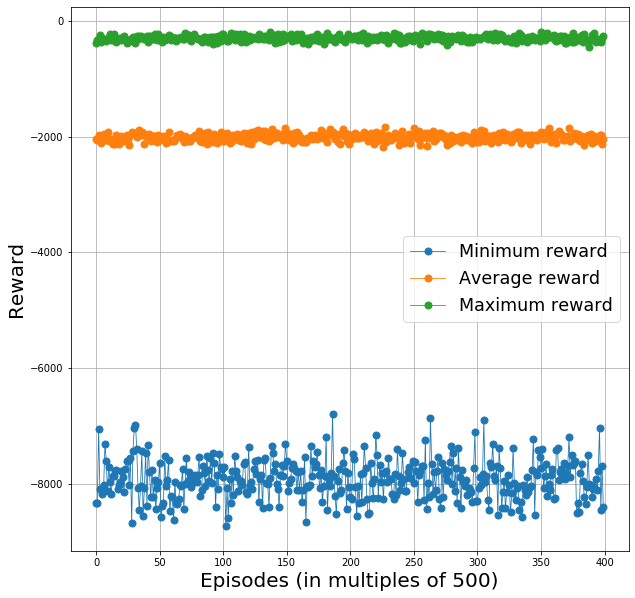

In [97]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,9))
line1, = plt.plot(min_reward,  marker='o', linestyle='-', linewidth=0.8,  markersize=7, label='Minimum reward')
line2, = plt.plot(avg_reward,  marker='o', linestyle='-', linewidth=0.8, markersize=7, label='Average reward')
line3, = plt.plot(max_reward,  marker='o', linestyle='-', linewidth=0.8,  markersize=7, label='Maximum reward')
plt.xlabel('Episodes (in multiples of 500)', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.legend(handles=[line1, line2, line3], fontsize=17.5)
plt.grid(True)
plt.savefig('monte_carlo_best_plot.pdf')
plt.show()

In [57]:
agent93 = MonteCarlo()
agent93.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.9) \
                                    + '_ep_' + str(0.3)
agent93.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.9) \
                                    + '_ep_' + str(0.3)
agent93.restore_Q_table()
print(len(agent93.rewards))
print(len(agent93.Q.keys()))

Restoration successful
200000
713


In [56]:
agent81 = MonteCarlo()
agent81.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.8) \
                                    + '_ep_' + str(0.1)
agent81.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.8) \
                                    + '_ep_' + str(0.1)

agent81.restore_Q_table()
print(len(agent81.rewards))
print(len(agent81.Q.keys()))

Restoration successful
200000
736


In [59]:
agent82 = MonteCarlo()
agent82.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.8) \
                                    + '_ep_' + str(0.2)
agent82.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.8) \
                                    + '_ep_' + str(0.2)
agent82.restore_Q_table()
print(len(agent82.rewards))
print(len(agent82.Q.keys()))

Restoration successful
200000
393


In [60]:
agent83 = MonteCarlo()
agent83.restore_file_q_table = 'Q_table_backup/200000/Q_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.8) \
                                    + '_ep_' + str(0.3)
agent83.restore_file_rewards = 'Q_table_backup/200000/rew_wind_' + str(True) + '_controller_' \
                                    + str(True) + '_df_' + str(0.8) \
                                    + '_ep_' + str(0.3)
agent83.restore_Q_table()
print(len(agent83.rewards))
print(len(agent83.Q.keys()))

Restoration successful
100000
636


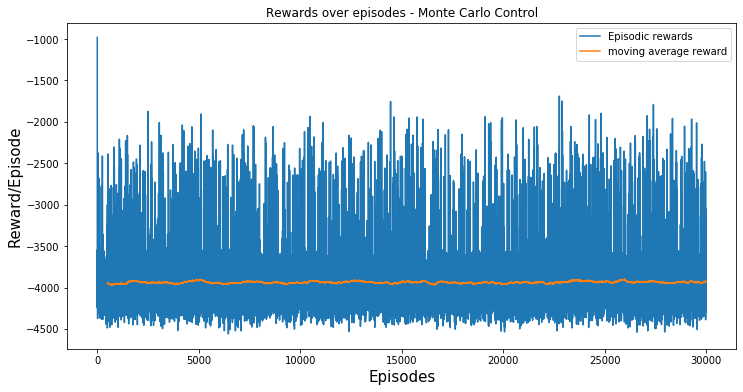

In [47]:
agent91.plot_analysis()

/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


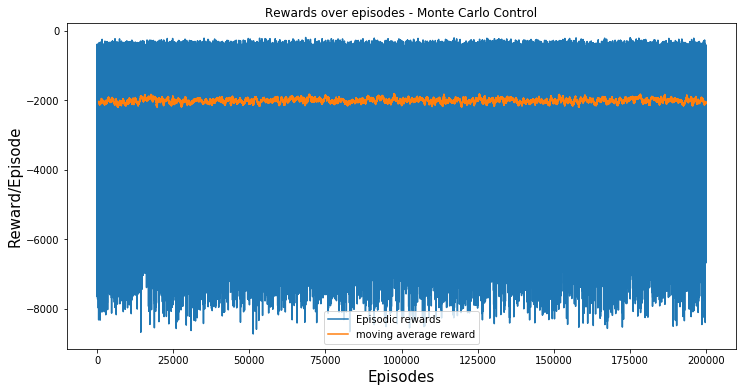

In [72]:
agent92.plot_analysis()

/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


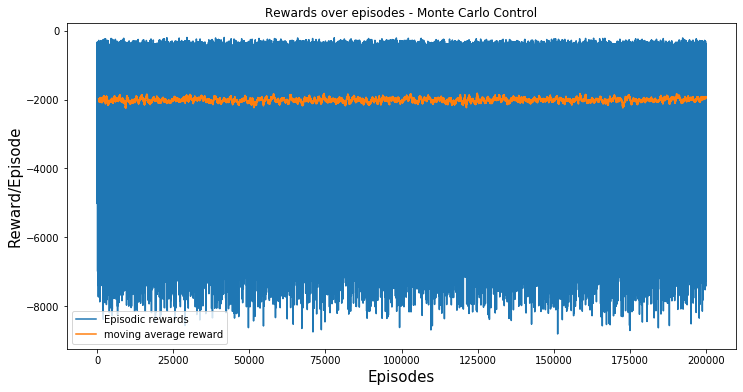

In [42]:
agent93.plot_analysis()

In [35]:
agent81 = MonteCarlo()
agent81.discount_factor = 0.8
agent81.epsilon = 0.1
agent81.restore_Q_table()
len(agent.rewards)

/home/sayanta/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Restoration successful


200000

/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


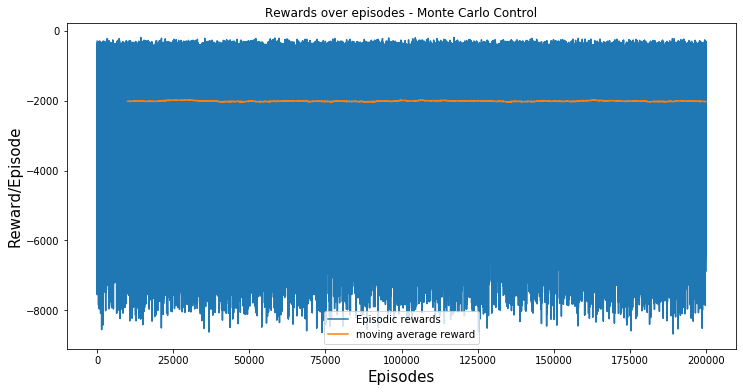

In [37]:
agent81.plot_analysis()

In [44]:
agent82 = MonteCarlo()
agent82.discount_factor = 0.8
agent82.epsilon = 0.2
agent82.restore_Q_table()
len(agent.rewards)

Restoration successful


/home/sayanta/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


200000

/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/sayanta/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


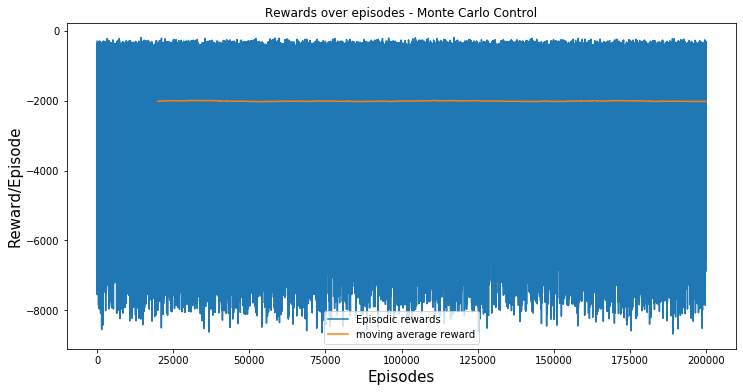

In [45]:
agent82.plot_analysis()